In [1]:
# gdrive mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [3]:
def data_info(direct):
  files = [file.strip() for file in os.listdir(direct)]
  filenames = []     
  for file in files:
    add = [file[:-4],file[0]]
    filenames.append(add)
  return filenames

In [4]:
# train, test
df_train = data_info("/content/gdrive/MyDrive/Fingerprint-Recognition/data/train")
df_test = data_info("/content/gdrive/MyDrive/Fingerprint-Recognition/data/test")

train = pd.DataFrame(df_train, columns =['filename', 'label']) 
test = pd.DataFrame(df_test, columns = ['filename', 'label'])
display(train.head(), test.head())

filename label
0    7 (5)     7
1    7 (6)     7
2    2 (6)     2
3    3 (6)     3
4    7 (4)     7

filename label
0       41     4
1       45     4
2        2     2
3        1     1
4       44     4

In [5]:
def pixel_info(direct, df):
  pixels = []
  for file in list(df['filename']):
    from PIL import Image
    im = Image.open(direct+'/'+file+'.bmp')
    pix = list(im.getdata())   
    pixels.append(pix)

  df_pix = pd.DataFrame(pixels, columns = list(range(144**2)))  # pixel data dataframe
  return df_pix

In [6]:
train_pix = pixel_info("/content/gdrive/MyDrive/Fingerprint-Recognition/data/train", train)
test_pix = pixel_info("/content/gdrive/MyDrive/Fingerprint-Recognition/data/test", test)

In [7]:
display(train_pix.head(), test_pix.head())

0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   20726  20727  20728  20729  20730  20731  20732  20733  20734  20735  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 20736 columns]

0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   20726  20727  20728  20729  20730  20731  20732  20733  20734  20735  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 20736 columns]

In [12]:
import imageio
import glob
list_dirs_te = list(glob.glob("/content/gdrive/MyDrive/Fingerprint-Recognition/data/test/*.bmp"))
list_dirs_tr = list(glob.glob("/content/gdrive/MyDrive/Fingerprint-Recognition/data/train/*.bmp"))
num_images_te = len(list_dirs_te)
num_images_tr = len(list_dirs_tr)
img_te = [None]*num_images_te
img_tr = [None]*num_images_tr

for i in range(num_images_tr):
  img_tr[i] = imageio.imread(list_dirs_tr[i])

for i in range(num_images_te):
  img_te[i] = imageio.imread(list_dirs_te[i])

import cv2
for i in range(num_images_tr):
  img_tr[i] = cv2.medianBlur(img_tr[i],1)

for i in range(num_images_te):
  img_te[i] = cv2.medianBlur(img_te[i],1)

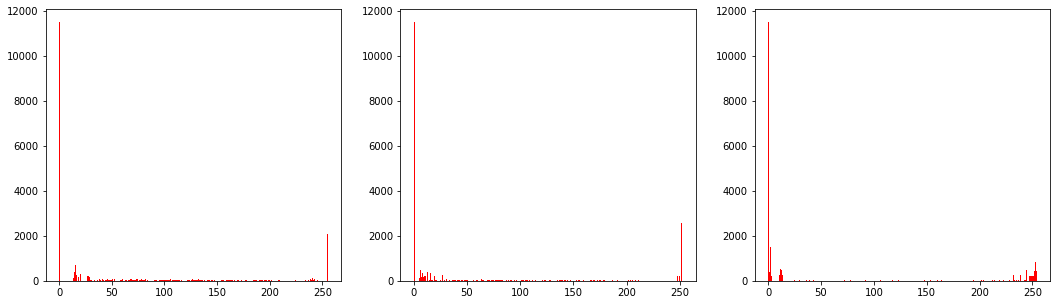

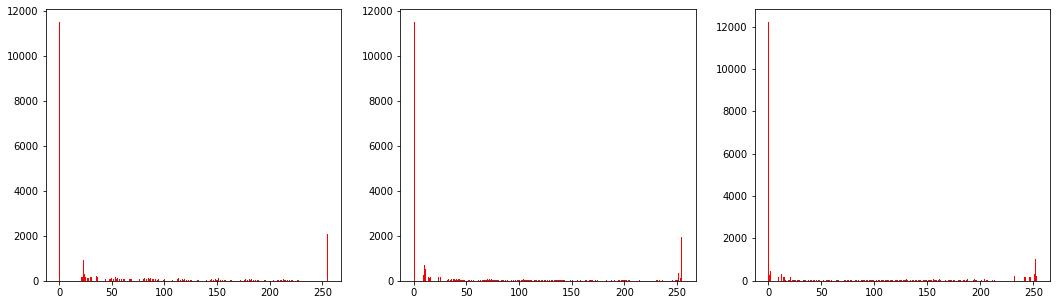

In [13]:
fig1, axes1 = plt.subplots(1,3,figsize = (18,5))
for i in range(3):
  axes1[i].hist(img_te[i].ravel(), bins=256, color ="r")
fig2, axes2 = plt.subplots(1,3,figsize = (18,5))
for i in range(3):
  axes2[i].hist(img_tr[i].ravel(), bins=256, color ="r")  

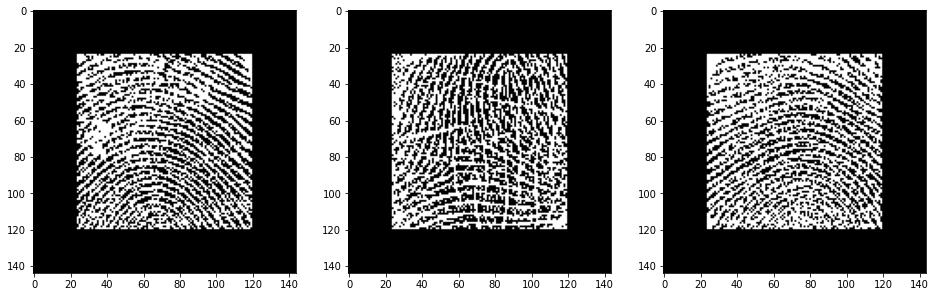

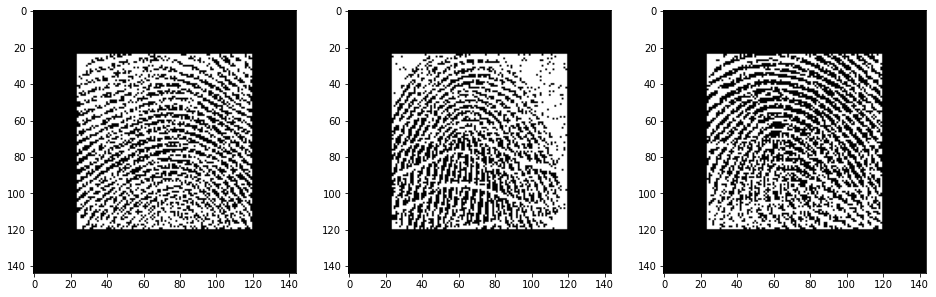

In [38]:
Thresh_te =[None] * num_images_te

for i in range(num_images_te):
  Thresh_te[i] = img_te[i].mean()
  img_te[i] = np.array(img_te[i] > Thresh_te[i]).astype(int) * 255

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(img_te[1],cmap="gray");
axes[1].imshow(img_te[2],cmap="gray");
axes[2].imshow(img_te[3],cmap="gray");

Thresh_tr =[None] * num_images_tr

for i in range(num_images_tr):
  Thresh_tr[i] = img_tr[i].mean()
  img_tr[i] = np.array(img_tr[i] > Thresh_tr[i]).astype(int) * 255

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(img_tr[1],cmap="gray");
axes[1].imshow(img_tr[2],cmap="gray");
axes[2].imshow(img_tr[3],cmap="gray");

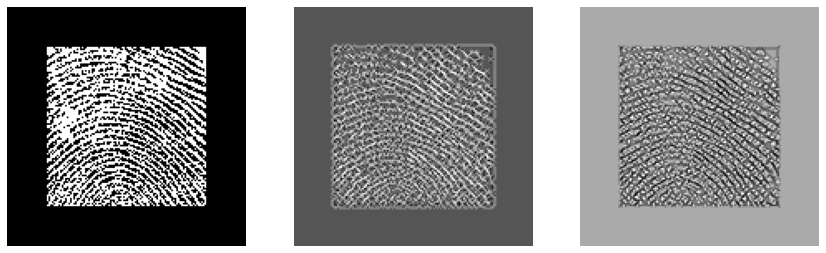

In [39]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
def detect_ridges(gray, sigma= 0.1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True, figsize = (12,12))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()


for i in range(num_images_tr):
  a_tr, b_tr = detect_ridges(img_tr[i], sigma=0.15)

for i in range(num_images_te):
  a_te, b_te = detect_ridges(img_te[i], sigma=0.15)

plot_images(img_te[1], a_te, b_te)

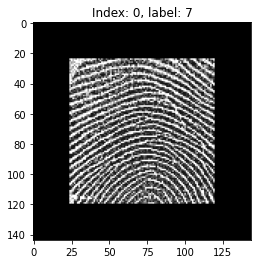

In [41]:
idx = 0
img = train_pix.loc[idx, '0':].values.reshape(144, 144).astype(int)
label = train.loc[idx, 'label']

plt.title('Index: %i, label: %s'%(idx, label))
plt.imshow(img,cmap="gray")
plt.show()

Train-Test-Split

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train_pix.values, train['label'], test_size = 0.3, random_state=42, shuffle=True, stratify=None)

X_train = X_train.reshape(-1, 144, 144, 1)
X_train = X_train/255

X_val = X_val.reshape(-1, 144, 144, 1)
X_val = X_val/255

X_test = test_pix.values.reshape(-1, 144, 144, 1)
X_test = X_test/255

# train/test label one-hot-encoding
y_train_vec = np.zeros((len(y_train), 8))
for i, digit in enumerate(y_train):
    y_train_vec[int(i), int(digit)-1] = 1

y_val_vec = np.zeros((len(y_val), 8))
for i, digit in enumerate(y_val):
    y_val_vec[int(i), int(digit)-1] = 1

CNN Model

In [43]:
#Data Augmentation

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, #set input mean to 0 over dataset
    samplewise_center=False, #set each sample mean to 0
    featurewise_std_normalization=False, #divide inputs by std of dataset
    samplewise_std_normalization=False, #divide each input by its std
    zca_whitening=False, #apply ZCA whitening
    rotation_range=10, #randomly rotate images (10 degrees)
    width_shift_range=0.1, #randomly shift images horizontally (10% of the width)
    height_shift_range=0.1, #randomly shift images vertically(10% of height)
    zoom_range=0.1, #randomly zoom image (10%)
    horizontal_flip=False, #rahdomly flip image
    vertical_flip=True, #randomly flip image
)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

nb_classes = 8
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)


model = Sequential([
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], padding='valid', input_shape=X_train.shape[1:], activation = 'relu'),
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu'),
                  MaxPooling2D(pool_size=pool_size),
                  Dropout(0.25),

                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dropout(0.5),
                  Dense(nb_classes, activation = 'softmax')
])

In [45]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer= 'adam' , metrics=['accuracy'])

In [56]:
batch = 8
epoch = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./model/model_cnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [57]:
history = model.fit(X_train, y_train_vec, epochs=epoch, callbacks=[es, mc], batch_size=batch, validation_data=(X_val, y_val_vec))

Epoch 1/10
1/7 [===>..........................] - ETA: 0s - loss: 0.0867 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.95833, saving model to ./model/model_cnn.h5
7/7 [==============================] - 0s 16ms/step - loss: 0.0989 - accuracy: 1.0000 - val_loss: 0.1311 - val_accuracy: 0.9583
Epoch 2/10
1/7 [===>..........................] - ETA: 0s - loss: 0.2180 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.95833
7/7 [==============================] - 0s 10ms/step - loss: 0.1218 - accuracy: 1.0000 - val_loss: 0.1014 - val_accuracy: 0.9583
Epoch 3/10
1/7 [===>..........................] - ETA: 0s - loss: 0.1709 - accuracy: 0.8750
Epoch 3: val_accuracy did not improve from 0.95833
7/7 [==============================] - 0s 7ms/step - loss: 0.0782 - accuracy: 0.9821 - val_loss: 0.1026 - val_accuracy: 0.9583
Epoch 4/10
1/7 [===>..........................] - ETA: 0s - loss: 0.0662 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.95833
7/7 [=

In [58]:
from tensorflow.keras.models import load_model

best = load_model('./model/model_cnn.h5')

In [59]:
# validation data
val_predict = np.argmax(best.predict(X_val), axis=1)

print("\n Validation: %.4f" % (best.evaluate(X_val, y_val_vec)[1]))
print(classification_report(np.argmax(y_val_vec, axis=1),val_predict))

1/1 [==============================] - 0s 130ms/step - loss: 0.1311 - accuracy: 0.9583

 Validation: 0.9583
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2

    accuracy                           0.96        24
   macro avg       0.95      0.96      0.95        24
weighted avg       0.97      0.96      0.96        24



In [60]:
test_predict = np.argmax(best.predict(X_test), axis=1)
true_class = [pred+1 for pred in test_predict]

test['label'] = true_class

In [61]:
test['filename'] = pd.to_numeric(test["filename"])
test

filename  label
0         41      7
1         45      8
2          2      8
3          1      7
4         44      8
..       ...    ...
75        76      1
76        20      3
77        28      5
78        23      2
79        19      8

[80 rows x 2 columns]

In [62]:
result = test.sort_values(by=['filename'], ascending=True)
result.head()

filename  label
3          1      7
2          2      8
66         3      2
45         4      8
30         5      1